Imports + Load Data

In [42]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

# Load sentiment output 
df = pd.read_csv("../data/sentiment/sentiment_scores.csv")

df["review_text"] = df["review_text"].fillna("").astype(str)
df.head()


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,sentiment_label,sentiment_score
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,2025,11,BOA,Abyssinia Bank,Yasin Alemu,0,2,Google Play,neutral,0.0000
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,2025,11,BOA,Abyssinia Bank,Wariyo Dida,0,9,Google Play,positive,0.4927
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,BOA,Abyssinia Bank,Hailegebrail Tegegn,0,4,Google Play,neutral,0.0000
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,2025,11,BOA,Abyssinia Bank,Tsegay ab,0,5,Google Play,positive,0.4926
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Abyssinia Bank,Yohanis Fikadu,0,8,Google Play,positive,0.4404


Extract Top Keywords Per Bank

In [43]:
top_keywords = defaultdict(list)

for bank in df["bank_name"].unique():
    subset = df[df["bank_name"] == bank]
    vec = vectorizer.transform(subset["review_text"])
    mean_scores = vec.mean(axis=0).A1
    top = mean_scores.argsort()[-10:][::-1]
    top_keywords[bank] = [keywords[i] for i in top]

top_keywords


defaultdict(list,
            {'Abyssinia Bank': ['app',
              'good',
              'best',
              'bank',
              'boa',
              'work',
              'worst',
              'nice',
              'like',
              'working'],
             'Commercial Bank of Ethiopia': ['good',
              'app',
              'best',
              'nice',
              'cbe',
              'bank',
              'good app',
              'like',
              'update',
              'application'],
             'Dashen Bank': ['app',
              'good',
              'best',
              'bank',
              'nice',
              'dashen',
              'wow',
              'super',
              'banking',
              'amazing']})

Build Enhanced Stopword Set + Text Cleaning

In [44]:
# --------------------------
# 1. Custom Stopword Expansion
# --------------------------

sentiment_words = {
    "good","bad","great","excellent","amazing","super","best",
    "nice","love","like","wow","better","worst","awesome",
    "cool","fantastic","perfect","helpful","easy","working","work","thank"
}

generic_words = {
    "app","mobile","banking","bank","application","user","friendly",
    "ethiopia","service","customer","support","experience"
}

bank_names = {
    "cbe","boa","dashen","dashen bank","commercial bank","bank of abyssinia"
}

extra_stop = sentiment_words | generic_words | bank_names

# --------------------------
# 2. Text Normalization
# --------------------------

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    tokens = [w for w in text.split() if w not in extra_stop and len(w) > 2]
    return " ".join(tokens)

df["clean_text"] = df["review_text"].apply(clean_text)
df.head()


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,sentiment_label,sentiment_score,clean_text
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,2025,11,BOA,Abyssinia Bank,Yasin Alemu,0,2,Google Play,neutral,0.0000,
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,2025,11,BOA,Abyssinia Bank,Wariyo Dida,0,9,Google Play,positive,0.4927,very
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,BOA,Abyssinia Bank,Hailegebrail Tegegn,0,4,Google Play,neutral,0.0000,goof
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,2025,11,BOA,Abyssinia Bank,Tsegay ab,0,5,Google Play,positive,0.4926,
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Abyssinia Bank,Yohanis Fikadu,0,8,Google Play,positive,0.4404,jop


Group Data by Bank for Theme Extraction

In [45]:
groups = df.groupby("bank_code")["clean_text"].apply(list).to_dict()
groups


{'BOA': ['',
  'very',
  'goof',
  '',
  'jop',
  'exprience crushed',
  'not all requires huge connectivity and also lags many times',
  '',
  'very',
  'most the time not properly',
  '',
  'not use for',
  'keeps notifying disable developer options and quiet while not enabled always bring another type problem with new updates',
  'waw',
  'the lag unbelievable when you need the most this suks',
  'cant belive could find the ever yet very simple fix the problem and the company just ignored body can business with this kind',
  '',
  'not all',
  'but was live abroad and when enter otp code didnt make write code the want self write thats not fair please other wise why',
  'when trying activate the keeps loading the security questions page has been two days',
  'fast and simple',
  '',
  'worest ever seen fake leave',
  '',
  'would share feedback regarding the frequently experiences disruptions and does not function properly often freezing failing load this issue affecting workflow and

TF-IDF Theme Extraction Function

In [46]:
def extract_themes(texts, top_n=10):
    """
    Extract top keywords/themes using TF-IDF.
    Removes stopwords and prefers bigrams over single words.
    """
    
    valid = [t for t in texts if t.strip()]
    if not valid:
        return ["Other"]

    vectorizer = TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),  # Allow bigrams
        max_features=2000
    )
    
    X = vectorizer.fit_transform(valid)

    terms = vectorizer.get_feature_names_out()
    scores = X.mean(axis=0).A1

    # Remove leftover unwanted terms
    filtered = [
        (term, score)
        for term, score in zip(terms, scores)
        if not any(sw in term for sw in extra_stop)
        and len(term) > 3
    ]

    filtered.sort(key=lambda x: x[1], reverse=True)
    return [t for t, s in filtered[:top_n]]


Generate Top Keywords per Bank

In [47]:
top_keywords = {bank: extract_themes(texts) for bank, texts in groups.items()}
top_keywords


{'BOA': ['doesn',
  'fast',
  'slow',
  'update',
  'time',
  'money',
  'goof',
  'open',
  'worest',
  'need'],
 'CBE': ['useful',
  'smart',
  'fast',
  'update',
  'money',
  'account',
  'transfer',
  'special',
  'make',
  'transaction'],
 'Dashen': ['fast',
  'slow',
  'ahead',
  'step',
  'version',
  'simple',
  'seen',
  'using',
  'time',
  'need']}

Theme Classification Function

In [52]:
def classify_theme(keywords):
    text = " ".join(keywords).lower()

    themes = []

    # PERFORMANCE — only if negative signals exist
    if any(w in text for w in ["slow", "crash", "lag", "freeze", "hang"]):
        themes.append("Performance Issues")

    # LOGIN / ACCESS
    if any(w in text for w in ["login", "password", "open", "reset", "doesn"]):
        themes.append("Login / Access Issues")

    # TRANSACTIONS / FEATURES
    if any(w in text for w in ["transfer", "money", "send", "pay"]):
        themes.append("Transaction / Feature Issues")

    # POSITIVE EXPERIENCE
    if any(w in text for w in ["easy", "friendly", "convenient", "simple"]):
        themes.append("Positive Ease of Use")

    # UI/UX
    if any(w in text for w in ["interface", "design", "navigation", "experience"]):
        themes.append("UI/UX")

    # UPDATE ISSUES — only if negative signals present
    if ("update" in text) and any(w in text for w in ["bad", "error", "problem", "issue", "fix"]):
        themes.append("Update Problems")

    # If nothing matched
    if not themes:
        themes.append("Other")

    return themes


Apply Theme Classification

In [53]:
theme_dict = {
    bank: classify_theme(kws)
    for bank, kws in top_keywords.items()
}

theme_dict


{'BOA': ['Performance Issues',
  'Login / Access Issues',
  'Transaction / Feature Issues'],
 'CBE': ['Transaction / Feature Issues'],
 'Dashen': ['Performance Issues', 'Positive Ease of Use']}

Save Theme Results

In [54]:
theme_df = pd.DataFrame([
    {
        "bank_code": bank,
        "keywords": ", ".join(kws),
        "themes": ", ".join(theme_dict[bank])
    }
    for bank, kws in top_keywords.items()
])

theme_df.to_csv("../data/sentiment/theme_results.csv", index=False)
theme_df


,bank_code,keywords,themes
0,BOA,"doesn, fast, slow, update, time, money, goof, ...","Performance Issues, Login / Access Issues, Tra..."
1,CBE,"useful, smart, fast, update, money, account, t...",Transaction / Feature Issues
2,Dashen,"fast, slow, ahead, step, version, simple, seen...","Performance Issues, Positive Ease of Use"


Visualization (Themes Per Bank)

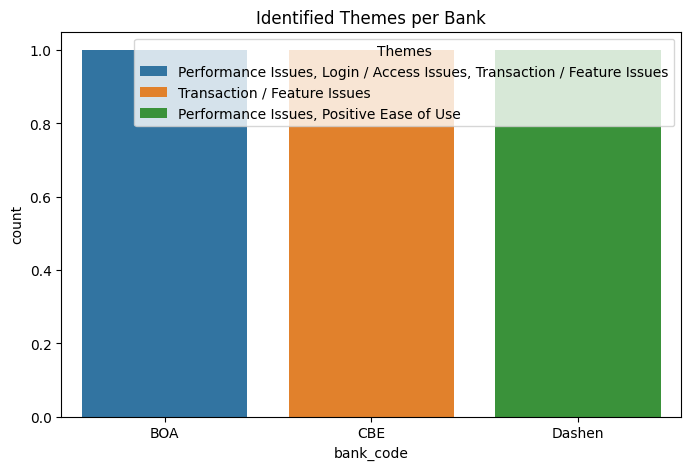

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=theme_df, x="bank_code", hue="themes")
plt.title("Identified Themes per Bank")
plt.legend(title="Themes")
plt.show()
